<a href="https://colab.research.google.com/github/takumi19910112/google_colab/blob/main/rag_getting_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 今日のゴール

1. **RAGとは何か簡単に理解する**
   - Retrieval-Augmented Generation（RAG）の基本的な概念とその目的を把握します。

2. **RAGの簡単な実装を通して、RAGのイメージを掴む**
   - 実装を行うことで、RAGがどのように機能するかを実践的に理解します。

3. **今日の話を聞くと、アリソンさんの記事とか、RAGの記事がより理解できるようになるかも？**
  - アリソンさんのテックブログ<br>
  https://www.divx.co.jp/media/243
   - 教養レベルのRAGの話<br>
   https://zenn.dev/umi_mori/books/llm-rag-langchain-python<br>
https://internet.watch.impress.co.jp/docs/column/shimizu/1580947.html<br>
https://zenn.dev/microcms/articles/f39a09d8f1ac01<br>
  - エンジニア向けのRAGの話<br>
https://fintan.jp/page/10301/<br>
https://qiita.com/jw-automation/items/045917be7b558509fdf2<br>
https://qiita.com/FukuharaYohei/items/0949aaac17f7b0a4c807<br>
https://acro-engineer.hatenablog.com/entry/2024/09/18/120000

## RAGとは

RAG = **Retrieval-Augmented Generation**

- **Retrieve（検索）**:
  - 情報を検索すること。

- **RAGの目的**:
  - 大規模言語モデル（LLM）の性能を維持しつつ、外部のデータベースから情報を引き出して回答を生成します。
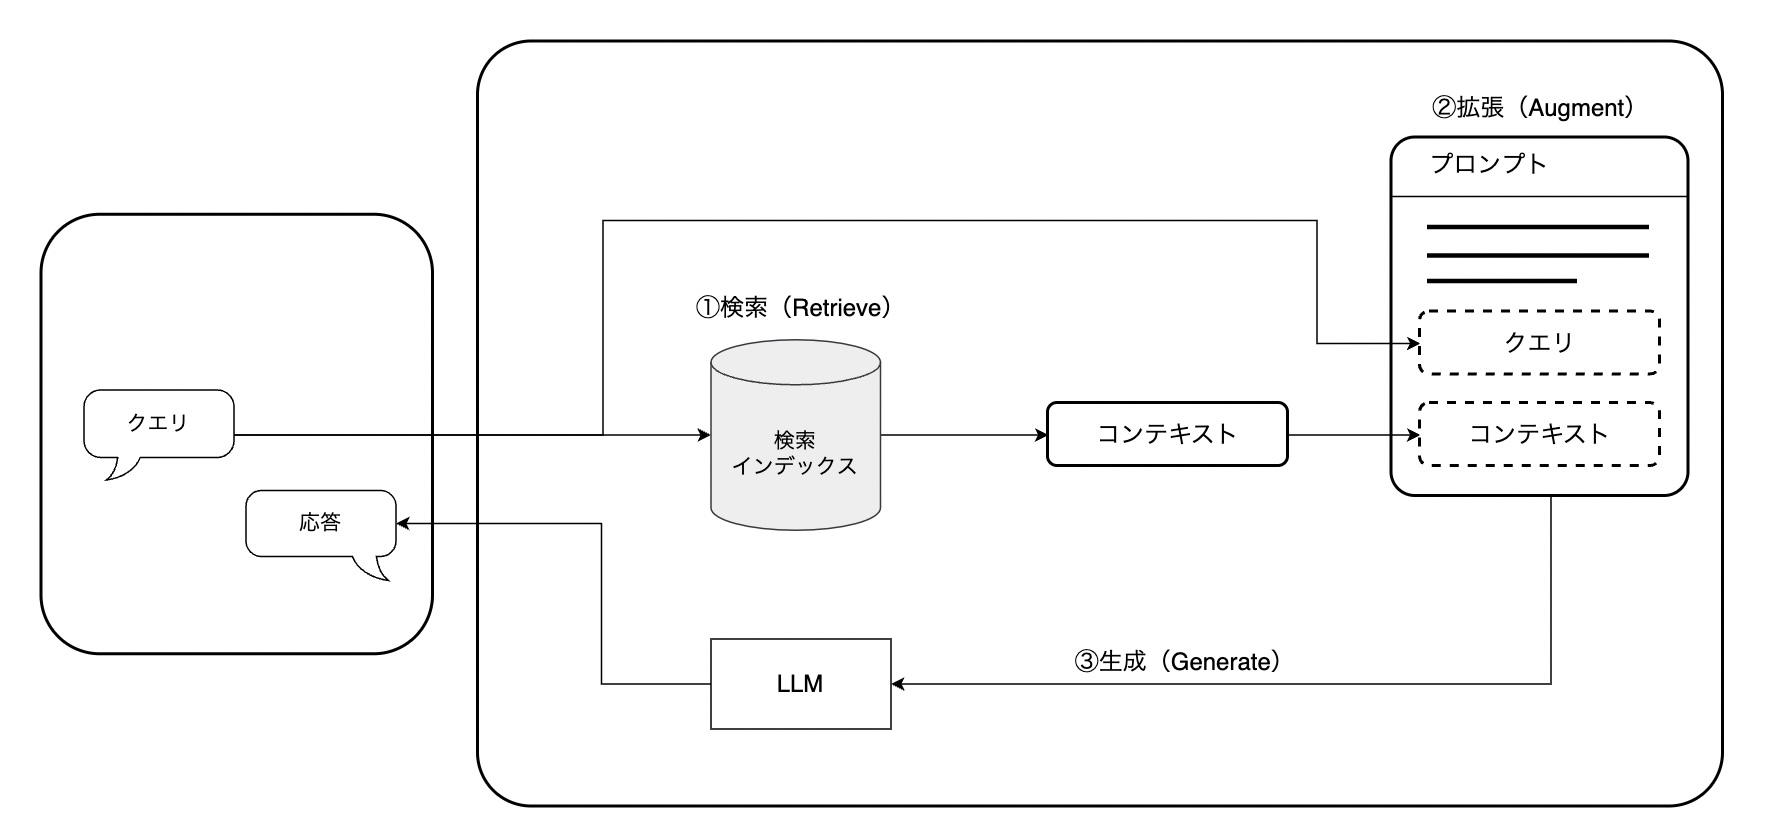

In [ ]:
# ドライブをマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# geminiの導入
import os
from google.colab import userdata
import google.generativeai as genai

# Google APIキーを取得
google_api_key = userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"] = google_api_key  # APIキーを環境変数に設定

"""
コードを実行するには、 GeiminiのAPIキーとhugging faceのAPIキーが必要です
GeminiのAPIキーを取得するには下記のサイトでAPIキーを取得してください
https://ai.google.dev/gemini-api/docs?hl=ja

初めてhugging faceを利用する場合は、以下のサイトでAPIキーを取得してください
https://huggingface.co/

APIキーはgoogle colabの左側の鍵アイコンのところに環境変数として追加してください
"""


# Geminiを試しに呼び出してみます
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content("彼は道を歩く際に足音が極端に静かなので、なぜそんなに静かなのか尋ねるとこう答えました。「クセになってんだ　音殺して動くの」彼は何の職業ですか？")

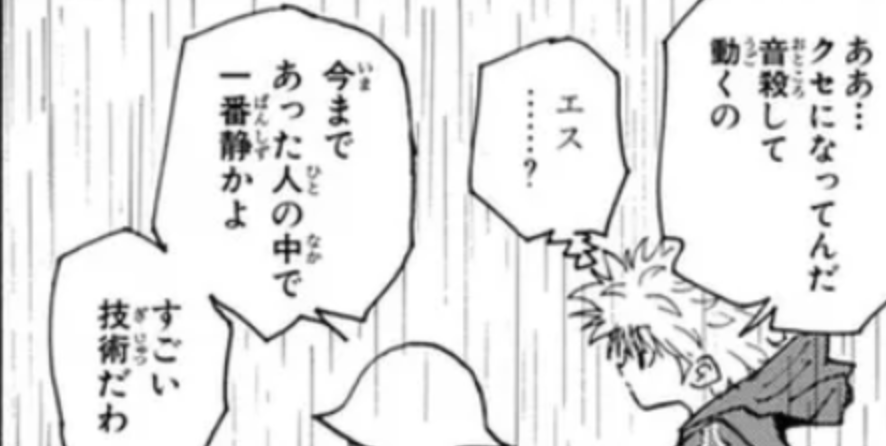

In [ ]:
print(response.text)

この文脈から考えると、彼は**忍者**か、**諜報員**のような職業の可能性が高いです。  極端に静かに動くことは、これらの職業において不可欠なスキルだからです。



In [ ]:
# 一般的に汎用LLMは企業独自の質問に答えることができない
prompt = """
以下の質問に日本語で回答してください:
質問:ナスビ＝ホイコーロ国王はどこの国の王ですか？
回答:"""
response = model.generate_content(prompt)
print(response.text)

ナスビ＝ホイコーロ国王は架空の人物です。そのため、どこの国の王でもありません。



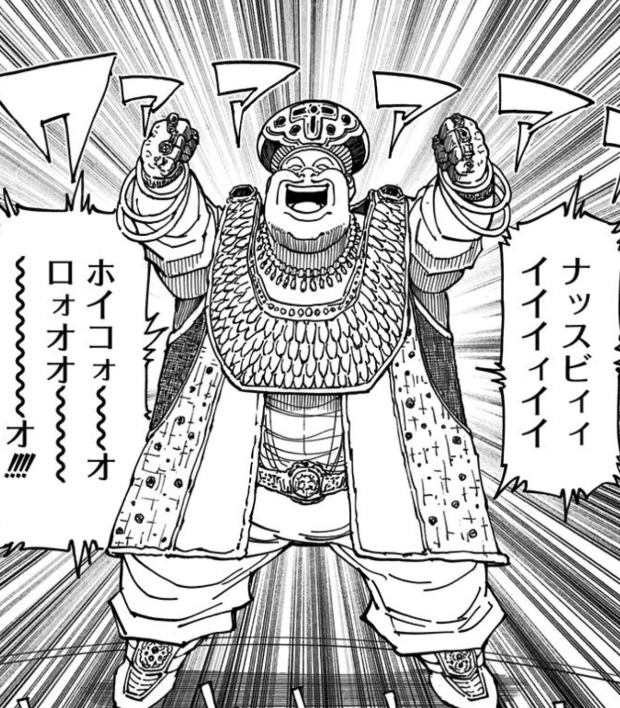

# RAGの基本的な流れ

## 1. データの準備
- **情報の用意**:
  - 答えを作るための資料やデータを集めます。
- **データの分割**:
  - 大きな資料を小さな部分（チャンク）に分けます。

## 2. データのベクトル化
- **チャンクをベクトル化**:
  - 各チャンクをコンピュータが扱いやすい数値情報（ベクトル）に変換します。
- **ベクトルの保存**:
  - 変換したベクトルを後で素早く検索できるように保存します。

## 3. 質問の処理
- **質問の受付**:
  - ユーザーからの質問を受け取ります。
- **質問をベクトル化**:
  - 質問もベクトルに変換します。

## 4. 関連情報の検索
- **類似度検索**:
  - 質問のベクトルと資料のベクトルを比較して、関連性の高い情報を探します。

## 5. プロンプトの編成
- **情報の取り込み**:
  - 見つけた情報を使って、言語モデルに渡すための下書き（プロンプト）を作成します。

## 6. 答えの生成
- **言語モデルで回答生成**:
  - プロンプトを言語モデルに入力し、答えを生成します。


In [ ]:
# 必要なライブラリをインストール
!pip install sentence-transformers # 埋め込み用
!pip install faiss-cpu             # 高速ベクトル検索用

# ライブラリのインポート
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 82.2 MB/s eta 0:00:00


# 埋め込みモデル（Embedding Model）とは何か？

## 1. 埋め込みモデルの役割
- テキスト（文章や単語）をコンピュータが理解できる数値ベクトルに変えるモデルです。
- これにより、文章の意味や特徴を数値で表現できます。

## 2. なぜ埋め込みが必要なのか？
- コンピュータは文字よりも数値の方が得意なので、テキストを数値に変換します。
- これにより、いくつかの目的が達成できます：

  - **意味の比較**：テキスト同士の意味がどれくらい似ているかを比較します。
  - **グループ化や分類**：似た内容をまとめたり、カテゴリに分けたりします。


In [ ]:
# 埋め込みモデルのロード（日本語対応のモデルを使用）
embedding_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

"""
SentenceTransformer とは？
- 文章をコンピュータが理解できる数値ベクトルに変えるツール。
- テキストの意味や文脈を捉えることができます。
- 多言語対応モデルを使うことで、日本語など様々な言語で使えます。
"""


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

'\nSentenceTransformer とは？\n- 文章をコンピュータが理解できる数値ベクトルに変えるツール。\n- テキストの意味や文脈を捉えることができます。\n- 多言語対応モデルを使うことで、日本語など様々な言語で使えます。\n'

# いっちゃん簡単なやつ
まずは、これをLLMにデータとして与えてみましょう

In [ ]:
# サンプルドキュメントのリスト
documents = [
    "カキン帝国のナスビ＝ホイコーロ国王が、世界の外側「暗黒大陸」への進出を突如宣言した。",
    "探検隊の責任者は、故ネテロ前会長の息子を名乗るビヨンド=ネテロであった。",
    "カキンのツェリードニヒ＝ホイコーロ第四王子は「緋の眼」を所有している。",
]

# チャンク化（Chunking）とは何か？

## 1. チャンク化の役割
- **チャンク化**とは、大きな文章やドキュメントを小さな部分に分けることです。
- これらの小さな部分を**チャンク（塊）**と呼びます。

## 2. なぜチャンク化が必要なのか？

- **検索をスムーズに**:
  - 小さな部分に分けておくと、必要な情報を探しやすくなります。

- **処理を軽くする**:
  - 大きなデータをそのまま扱うと大変なので、小分けにして計算負荷を減らします。

- **関連情報のピックアップ**:
  - 質問に対して的確な答えを見つけるために、関連する部分だけを取り出せます。


In [ ]:
# 今回はリストの要素の1つずつを1つのチャンク（塊）としてみましょう
chunks = documents

In [ ]:
# チャンクの埋め込みを取得
# さっきの埋め込みモデルを使って、チャンクをベクトル化します
chunk_embeddings = embedding_model.encode(chunks)

# ベクトルのインデックス化

## 目的
- **埋め込んだベクトルをすばやく検索**するためのインデックス（索引）を作成します。

## ポイント

1. **ベクトルの次元数**
   - `dimension`とは、ベクトルが持つ要素（長さ）の数を指します。

2. **インデックスの作成**
   - `faiss.IndexFlatL2(dimension)`を使って、ベクトル間の距離を計算しやすくします。
   - FAISSライブラリがこれを助けてくれます。

3. **チャンクをインデックスに追加**
   - `index.add(chunk_embeddings)`を使って、チャンクのベクトルをインデックスに加えます。

## FAISSとは？
- **FAISS（Facebook AI Similarity Search）**は、似たベクトルを素早く見つけるツールです。
- 大量のデータでも効率的に扱えます。

## L2距離とは？
- **L2距離（ユークリッド距離）**は、2つのベクトル間の直線距離です。
- 簡単に言うと、ベクトル同士がどれだけ近いのかを数値で示します。

## なぜインデックス化が重要なのか？
- ベクトルが少なければ直接比較できますが、多いと遅くなります。
- インデックス化することで、検索がずっと速くなります。


In [ ]:
dimension = chunk_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(chunk_embeddings)

In [ ]:
"""
dimensionは、チャンクをベクトル化したとき、そのベクトルが何次元ベクトルなのかを指しています
[1, 2] ->２次元ベクトル
[2, 2, 2] ->３次元ベクトル
"""
print(dimension)

384


In [ ]:
"""
indexは、データ構造の一種です
データ構造->データを整理して保存し、効率的に操作するための手法や仕組みのこと
データ構造の例：配列とか、スタックとか、キューとか
indexは多次元ベクトルを管理するためのデータ構造です
このindexはFAISSというライブラリで提供されています
めちゃくちゃ簡単にいうと、ベクトル同士の類似性を計算してくれる機能を持っています
(ベクトル同士の類似性ってなんやねんって感じの人もいると思うのですが、とりあえず、ベクトル化される単語同士が似ていれば、単語をベクトル化しても似ていると捉えていいです)
"""
print(index)

<faiss.swigfaiss_avx512.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x79fde1835b30> >


In [ ]:
# ユーザーからの質問
question = "ナスビ＝ホイコーロ国王はどこの国の王ですか？"

# 質問の埋め込み取得
question_embedding = embedding_model.encode([question])

In [ ]:
# 類似度検索（上位3件を取得）
k = 3
distances, indices = index.search(question_embedding, k)

In [ ]:
"""
distances
解釈：質問と各チャンクの距離が表示されています。
値が小さいほど、質問に対してチャンクが「近い」（つまり、関連性が高い）ことを示します。
"""
print(distances)
"""
indicies
解釈：距離が近い順にチャンクのインデックスが表示されています。
indices[0] の各値は、chunks リストの要素の位置を示します。

documents = [
    "カキン帝国のナスビ＝ホイコーロ国王が、世界の外側「暗黒大陸」への進出を突如宣言した。",
    "探検隊の責任者は、故ネテロ前会長の息子を名乗るビヨンド=ネテロであった。",
    "カキンのツェリードニヒ＝ホイコーロ第四王子は「緋の眼」を所有している。",
]
"""
print(indices)

[[10.89694  12.883591 14.348243]]
[[0 2 1]]


つまり、分割したチャンクのうち、
「DIVXで一番偉い人は誰ですか？」に対して最も近い回答を有しているものは「DIVXでは物部さんがCEOです。」だということになります

In [ ]:
# 関連ドキュメントの取得
"""
検索結果のうち、最も近いチャンクのインデックスを取得して、それを元のdocumentsリストから取得します。
"""
retrieved_chunks = [chunks[idx] for idx in indices[0]]
print(retrieved_chunks)

['カキン帝国のナスビ＝ホイコーロ国王が、世界の外側「暗黒大陸」への進出を突如宣言した。', 'カキンのツェリードニヒ＝ホイコーロ第四王子は「緋の眼」を所有している。', '探検隊の責任者は、故ネテロ前会長の息子を名乗るビヨンド=ネテロであった。']


In [ ]:
# コンテキストの作成
context = "\n".join(retrieved_chunks)

# プロンプトの作成
prompt = f"""
以下の知識を参考に、質問に日本語で回答してください。

知識:
{context}

質問:
{question}

回答:
"""


In [ ]:
# 言語モデルで回答を生成
response = model.generate_content(prompt)
print("-----生成結果-----\n", response.text)

-----生成結果-----
 ナスビ＝ホイコーロ国王はカキン帝国の王です。



<h1>長いテキストファイルを使用したRAGの実装</h1>

In [ ]:
# テキストファイルのパス
file_path = '/content/drive/MyDrive/hunter_hunter.txt'

# テキストファイルの読み込み
with open(file_path, 'r', encoding='utf-8') as f:
    full_text = f.read()

In [ ]:
# ファイルの内容を出力
print(full_text)

ハンター
怪物・財宝・賞金首・美食・遺跡・幻獣など、稀少な事物を追求することに生涯をかける人々の総称。ハンター自体は自称であるが、プロハンターの資格を有さない者はアマチュアとみさなれる。プロのハンターの資格を得るには、数百万分の一の難関と言われるハンター試験を突破しなければならない。しかし、この試験に合格してもさらに念能力を試す裏試験があり、これも突破しなければ一人前のハンターとはされない。ハンター試験に合格したプロハンターは全員がハンター協会の会員となる。現在の会員数は660名ほど。

一口にハンターと言っても、世界の財宝発掘を専門とする財宝ハンターやブラックリストに載っている犯罪者を捕らえることを専門とする賞金首ハンターといったように専門分野の違いによって様々に分かれている。ただし、これはハンターになった後本人がどういう仕事を重点的に行うかによる俗称であり、ハンター資格に種類があるわけではない。

この世界においてハンター協会は国境を超えて信頼性を持ち、そこに属するプロハンターはライセンスの持つ特権もあって莫大な富と名声を得られる。この世界での長者番付上位10名のうち6名がプロハンターであるなど「世界一儲かる」「世界一気高い」仕事であるとされる。

ハンター協会により「ハンター十ヶ条」が定められており、プロハンターの選出方法、プロとなったものの行動指針、ハンター協会の会長や参謀の選出方法など協会の運営方法などが規定されている。

ハンター試験に合格すれば誰でもプロハンターになれる。そしてハンターはハンターをむやみに狩れないことになっている。そのため、危険人物が試験を通過してしまうと手を出しづらくなっているという難点を内包している（例：シャルナーク、ヒソカ、イルミ、パリストンなど）。

ハンター試験とライセンス
ハンター試験
年に一度行われる、ハンター協会主催のハンターライセンス授与試験。12月31日で申込みが締め切られ、1月7日から試験が行われる。試験の数・期間は内容によって異なり、試験数は平均して5、6程度、期間は1週間で終わることもあれば1か月かかることもある。試験には毎年数百万人の参加者が集まるが、数万分の1、数十万分の1と言われる倍率を誇り、試験会場に辿り着ける者さえごく一握りである上、試験自体も死傷者が頻発するほど過酷を極めるため、合格者が一人も出なか

## 1.2 テキストのチャンク化

長いテキストをそのまま扱うと、メモリや計算負荷が高くなる可能性があります。適切なサイズに分割することで、検索精度を向上させることができます。ここではテキストのチャンク化方法について説明します。

### チャンク化の方法

- **文章単位での分割**:  
  テキストを句点（「。」）や改行で区切ります。この方法は文章構造を保ちながら分割でき、意味のある単位での検索がしやすくなります。

- **固定長での分割**:  
  一定の文字数またはトークン数ごとにテキストを分割します。この方法は文章の長さに関わらず、均一なデータサイズで処理できるため、計算負荷を管理しやすくなります。


In [ ]:
# コード例：文章単位での分割
import re

# 改行や句点でテキストを分割
sentences = re.split('。|．|\n', full_text)
# 空の文字列を除外
sentences = [s.strip() for s in sentences if s.strip()]

In [ ]:
# # コード例：固定長での分割
# def chunk_text(text, max_length=200):
#     # max_lengthごとにテキストを分割
#     return [text[i:i+max_length] for i in range(0, len(text), max_length)]

# chunks = chunk_text(full_text)

### ポイント

- **文章単位での分割**:
  - 文脈を保ちやすく、意味のある単位で分割できます。

- **固定長での分割**:
  - 文章が長すぎる場合や、文章区切りがうまくいかない場合に有効です。


## 1.3 RAGへの組み込み

### 全体の流れ

1. **チャンクの埋め込み取得**  
   - テキストチャンクをベクトル化し、埋め込みを取得します。

2. **FAISSによるインデックスの作成**  
   - 埋め込みを用いて、FAISS（Facebook AI Similarity Search）によるインデックスを構築します。

3. **ユーザーからの質問の処理**  
   - ユーザーからの質問を受け取り、その内容を解析します。

4. **関連チャンクの検索**  
   - 質問と関連性が高いチャンクをインデックスを利用して検索します。

5. **プロンプトの作成と回答の生成**  
   - 検索結果からプロンプトを作成し、適切な回答を生成します。


In [ ]:
# チャンク化したテキストを使用
chunks = sentences  # または chunks = chunk_text(full_text)

# チャンクの埋め込み取得
chunk_embeddings = embedding_model.encode(chunks)

# ベクトルをFAISSにインデックス化
dimension = chunk_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)  # L2距離での検索
index.add(chunk_embeddings)

# ユーザーからの質問
# question = "ヒソカによる各系統別の性格診断によると、強化系はどのような性格ですか？"
question = "水見式において変化系はどのような特徴がありますか？"

# 質問の埋め込み取得
question_embedding = embedding_model.encode([question])

# 類似度検索（上位3件を取得）
k = 3
distances, indices = index.search(question_embedding, k)

# 関連チャンクの取得
retrieved_chunks = [chunks[idx] for idx in indices[0]]

# コンテキストの作成
context = "\n".join(retrieved_chunks)

# プロンプトの作成
prompt = f"""
以下の知識を参考に、質問に日本語で回答してください。

知識:
{context}

質問:
{question}

回答:
"""

# モデルで回答を生成
response = model.generate_content(prompt)
print("-----生成結果-----\n", response.text)

-----生成結果-----
 水見式において、変化系はグラス内の水の量が変化するという特徴があります。また、記述されている通り、水見式では上記以外の変化も起きるため、変化系はそれら「上記以外の変化」と隣り合っている、つまり、複数の変化が同時に、もしくは連続して起こる可能性があります。



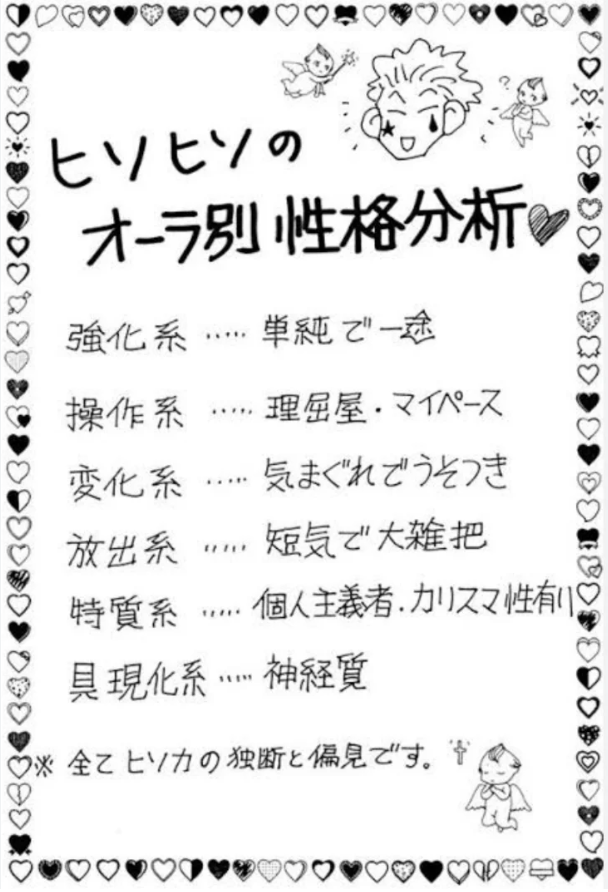

## ハルシネーションとRAGシステム

### 定義

ハルシネーション（Hallucination）とは、特に生成モデルがRAG（Retrieval-Augmented Generation）システムで回答を作成する際に、実際には存在しない情報や誤った情報を生成してしまう現象を指します。

### RAGシステムにおける関連性

- **関連チャンクの誤選択**: RAGシステムでは、インデックスから関連性の高いチャンクを検索するプロセスがありますが、このときに誤ったチャンクを選択すると、誤ったコンテキストが生成プロセスに影響を及ぼします。

- **不正確なモデル出力**: 質問に対して取り出された情報が不正確である場合、モデルの出力も不適切なものとなりやすく、結果的にハルシネーションが発生することがあります。

- **トレーニングデータの不足**: 不十分なトレーニングデータや、偏った情報からなるインデックスは、関連する情報を正確に提供できず、誤った回答へとつながります。

### 発生の原因

- **データの偏りまたは不足**: インデックス内のデータが偏っていたり欠如している場合には、的確な情報の抽出が難しくなります。

- **モデルの限界**: トレーニングされていない領域または予期しない質問に対処する際、存在しない情報を生成しやすくなります。

### 対策

- **データの多様化**: インデックスを含むトレーニングデータを多様化することで、正確な情報の抽出を支援します。

- **事実確認の強化**: 回答生成プロセス中に事実確認を行い、誤った情報の生成を抑えることが可能です。

- **監督とフィードバックの導入**: 出力結果を人間が監督し、必要に応じてフィードバックを提供することで、システム全体の改善に貢献します。

### まとめ

RAGシステムにおけるハルシネーションは、情報の検索と生成の両方の段階で発生し得る課題です。正確なデータと精緻なプロセスにより、そのリスクを大幅に軽減することができます。


<h1>Webページの内容を取得してRAGで利用する方法</h1>

In [ ]:
# webスクレイピング用のライブラリを入れる
!pip install requests beautifulsoup4

In [ ]:
import requests
from bs4 import BeautifulSoup

# スクレイピングするURLを指定
url = 'https://ja.wikipedia.org/wiki/HUNTER%C3%97HUNTER'  # 対象のウェブサイトのURLに変更してください

# ウェブページの取得
response = requests.get(url)
response.encoding = response.apparent_encoding  # エンコーディングを適切に設定

# BeautifulSoupでパース
soup = BeautifulSoup(response.text, 'html.parser')

# テキストの抽出（ここでは<p>タグ内のテキストを取得）
paragraphs = [p.get_text() for p in soup.find_all('p')]

# テキストを連結
full_text = '\n'.join(paragraphs)


### ポイント

- **Requestsライブラリの使用**:
  - `requests` ライブラリを使ってウェブページのコンテンツを取得します。

- **BeautifulSoupによるHTMLパース**:
  - `BeautifulSoup` を使ってHTMLをパースし、必要なテキストを抽出します。

- **データ範囲の設定**:
  - 取得するデータの範囲はページの構造に応じて調整します（例：`<p>`タグや `<div>`タグなど）。


In [ ]:
import re

# テキストのクリーンアップとチャンク化
sentences = re.split('。|．|\n', full_text)
sentences = [s.strip() for s in sentences if s.strip()]


In [ ]:
# チャンク化したテキストを使用
chunks = sentences

# チャンクの埋め込み取得
chunk_embeddings = embedding_model.encode(chunks)

# ベクトルをFAISSにインデックス化
dimension = chunk_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(chunk_embeddings)

# ユーザーからの質問
question = "ゾルディック家の住む場所はどんなところですか？"

# 質問の埋め込み取得
question_embedding = embedding_model.encode([question])

# 類似度検索（上位3件を取得）
k = 3
distances, indices = index.search(question_embedding, k)

# 関連チャンクの取得
retrieved_chunks = [chunks[idx] for idx in indices[0]]

# コンテキストの作成
context = "\n".join(retrieved_chunks)

# プロンプトの作成
prompt = f"""
以下の知識を参考に、質問に日本語で回答してください。

知識:
{context}

質問:
{question}

回答:
"""

# モデルで回答を生成
response = model.generate_content(prompt)
print("-----生成結果-----\n", response.text)

-----生成結果-----
 ゾルディック家の住む場所は、敷地に入るだけでも試しの門（黄泉への扉）を始めとする複数の、非常に困難な難関が待ち受ける、険しい場所です。  屋敷に至るまでにも、突破困難な障害物がいくつも存在するようです。



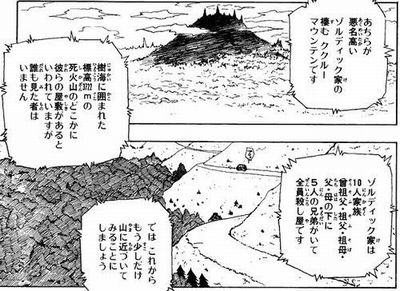

これまでに基本的なRAG（Retrieval-Augmented Generation）の実装を経験されて、理解が深まったとのこと、とても素晴らしいです。

次のステップとして、RAGの実運用レベルでの開発や、さらに高度な知識を身につけるために必要なポイントや学習方法を、専門用語をできるだけ噛み砕いてご説明します。

---

## 目次

1. [次のアクションプラン](#section1)
2. [重要な用語と考え方](#section2)
3. [具体的な練習方法](#section3)
4. [まとめ](#section4)

---

## 1. 次のアクションプラン

### 1-1. テキストの前処理とクリーンアップ

- 目的：テキストデータを整形し、一貫性のある形にすることで、モデルの性能を向上させる。
- アクション：
  - 不要な文字や記号の除去：テキストから不要な空白、改行、特殊記号などを取り除きます。
  - 正規化：例えば、「！」と「!」などの全角半角の統一、カタカナの表記揺れの統一など。
  - 誤字・脱字の修正：自動的に可能な範囲で誤字や脱字を修正します。

### 1-2. チャンク化の最適化

- 目的：適切な単位でテキストを分割し、情報の一貫性と検索効率を両立する。
- アクション：
  - 分割方法の検討：文章単位、段落単位、固定トークン数など、どの方法が最適か検討します。
  - チャンクの長さの調整：長すぎず短すぎないチャンクのサイズを試行錯誤します。
  - 重複のあるチャンク化：チャンク間に重なる部分を持たせることで、文脈を保つ方法を検討します。

### 1-3. 類似度計算の改善

- 目的：ユーザーの質問とチャンク間の関連性をより正確に評価する。
- アクション：
  - 類似度指標の見直し：L2距離だけでなく、コサイン類似度など他の指標を検討します。
  - 高度な検索アルゴリズムの導入：FAISSの高度な機能や他のベクトル検索エンジンを調査します。
  - 埋め込みモデルの選択：より性能の高い埋め込みモデルを試してみます。

### 1-4. モデルのファインチューニング（微調整）

- 目的：独自のデータに合わせてモデルを最適化し、回答の精度を向上させる。
- アクション：
  - 自分のデータでモデルを微調整：独自のドキュメントやQ&Aペアを使って、埋め込みモデルや言語モデルを微調整します。
  - 微調整の方法を学ぶ：モデルの微調整手順や注意点を学習します。

### 1-5. エラーハンドリングとロバスト性の向上

- 目的：システムが予期せぬ入力や状況に対しても安定して動作するようにする。
- アクション：
  - 例外処理の追加：ファイル読み込みやネットワークエラーなどに対処するコードを追加します。
  - 入力の検証：ユーザーからの入力が適切であるか確認し、不適切な場合はガイドを提供します。

### 1-6. デプロイとスケーリングの学習

- 目的：開発したシステムを実際の環境で運用できるようにする。
- アクション：
  - Webアプリケーション化：FlaskやFastAPIなどでAPIやWebアプリケーションとして公開します。
  - クラウド上でのデプロイ：AWS、GCP、Azureなどのクラウドサービスを使ってシステムをデプロイします。
  - スケーリングの学習：ユーザー数の増加に対応するためのスケーリング方法を学びます。

---

<a id="section2"></a>
## 2. 重要な用語と考え方

### 2-1. テキストの前処理

- 正規化：
  - テキスト内の表記ゆれ（例：「コンピュータ」と「コンピューター」）を統一すること。
  - 全角半角や大文字小文字の統一、記号の統一なども含まれます。

- ストップワードの除去：
  - 「の」「に」「は」など、意味を持たない（もしくは弱い）単語を削除すること。
  - 日本語では文脈によって意味が変わるため、慎重に検討する必要があります。

### 2-2. チャンク化

- オーバーラップウィンドウ：
  - チャンク間で一部のテキストを重複させる方法。これにより、文脈が切れないようにします。
  - 例えば、前のチャンクの最後の数行を次のチャンクの最初に含める。

- トークン数：
  - モデルが扱う単語や記号の最小単位。チャンクのサイズをトークン数で管理すると、モデルの入力制限に合わせやすい。

### 2-3. 類似度計算

- コサイン類似度：
  - ベクトル間の角度で類似度を測る方法。値は-1から1の間で、1に近いほど類似しています。
  - テキストの方向性（意味的な方向性）を重視します。

- ユークリッド距離（L2距離）：
  - ベクトル間の直線距離。値が小さいほど類似しています。
  - ベクトルの大きさ（スケール）が影響するため、正規化が必要な場合があります。

### 2-4. モデルの微調整

- ファインチューニング：
  - 既に学習済みのモデルに対して、新たなデータを用いて追加学習を行うこと。
  - 自分のデータに適したモデルに仕上げることで、性能を向上させます。

- 過学習：
  - モデルが学習データに対して過度に適合してしまい、新しいデータに対して性能が落ちる現象。
  - データの分割や正則化などで対策します。

### 2-5. デプロイとスケーリング

- API（アプリケーションプログラミングインターフェース）：
  - 別のプログラムから機能を呼び出せるようにするためのインターフェース。
  - REST APIなどを使って、システムを他のアプリケーションから利用可能にします。

- スケーリング：
  - システムの処理能力を増減させて、需要に対応すること。
  - 水平スケーリング：サーバーの台数を増減させる。
  - 垂直スケーリング：サーバーの性能（CPUやメモリ）を増減させる。

---

<a id="section3"></a>
## 3. 具体的な練習方法

### 3-1. テキスト前処理の練習

- 実際のテキストデータを用意：
  - ウェブから取得したニュース記事や、自由に利用可能なテキストデータを使います。
  - 著作権に注意し、公開されているデータセットを利用しましょう。

- 前処理スクリプトの作成：
  - 正規表現を使って、不要な文字や記号を削除する練習をします。
  - テキストの正規化や誤字修正を自動化する方法を検討します。

### 3-2. チャンク化とその評価

- 異なるチャンクサイズでの実験：
  - 文章単位、段落単位、固定トークン数など、さまざまな方法でチャンク化してみます。
  - 各方法での検索結果や回答の品質を比較し、最適な方法を見つけます。

- オーバーラップウィンドウの実装：
  - チャンク間に重なりを持たせる方法を実装し、文脈の保全効果を確認します。

### 3-3. 類似度指標の比較

- コサイン類似度の実装：
  - コサイン類似度を計算できるようにコードを修正し、L2距離との結果の違いを比較します。

- 検索結果の評価：
  - 同じ質問に対して、異なる類似度指標を使ったときの検索結果を比較し、どちらがより適切か評価します。

### 3-4. モデルの微調整

- 小規模なデータセットでの微調整：
  - 自分で作成したQ&Aペアを使って、埋め込みモデルを微調整してみます。
  - 微調整前後での性能の違いを確認します。

- 学習曲線の観察：
  - 微調整中の損失関数の値を記録し、モデルが学習しているか確認します。

### 3-5. システムのデプロイ

- 簡単なWebインターフェースの作成：
  - StreamlitやGradioなどのツールを使って、ユーザーが質問を入力できるインターフェースを作成します。

- クラウドサービスの利用：
  - Google Colab以外の環境で、システムをデプロイしてみます。
  - HerokuやRenderなどの無料で使えるサービスを試してみます。

---

<a id="section4"></a>
## 4. まとめ

### 重要なポイント

- データの品質がモデルの性能に直結：
  - 入力データの前処理を丁寧に行うことで、モデルの回答精度が向上します。
  
- チャンク化はバランスが重要：
  - チャンクが小さすぎると文脈が失われ、大きすぎると検索効率が落ちます。適切なサイズを見つけることが大切です。
  
- 類似度計算は結果に大きく影響：
  - 適切な類似度指標を選ぶことで、ユーザーの質問に対してより関連性の高い情報を提供できます。
  
- モデルの微調整で性能向上：
  - 自分のデータでモデルを微調整することで、システムがより自分のニーズに合ったものになります。

- 実践を通じて学ぶことが大切：
  - 自分で手を動かして実装し、試行錯誤することで理解が深まります。

### おすすめの学習リソース

- ブログやチュートリアル記事：
  - 「RAG 実装方法 初心者」などのキーワードで検索すると、日本語の解説記事が見つかります。

- オープンソースプロジェクトのコードの読み込み：
  - GitHubで公開されている類似のプロジェクトのコードを読むことで、他の人の実装方法を学べます。

- コミュニティへの参加：
  - Stack OverflowやQiitaなどで質問や情報交換を行いましょう。

---

## 最後に

一歩進んだ学習のためには、実際に手を動かして経験を積むことが最も効果的です。困ったことや疑問点があれば、ぜひ質問してください。一緒に学んでいきましょう！

---

頑張ってください！応援しています。